In [1]:
import fitsio as fio
import numpy as np
import os, sys
import glob
from matplotlib import pyplot as plt
import proplot as pplt
from tqdm import tqdm
import pickle
from des_y6utils import mdet
%matplotlib inline

os.environ["MEDS_DIR"] = "/global/cfs/cdirs/des/y6-shear-catalogs"

In [14]:
# grab mdet files (these files are divided into patches)
mdet_files = glob.glob('/global/cfs/cdirs/des/y6-shear-catalogs/metadetection_patches_v1_blinded/patch-*.fits')

In [ ]:
# preliminary shear weight
with open('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/inverse_variance_weight_final_v2.pickle', 'rb') as handle:
    wgt_dict = pickle.load(handle)

In [ ]:
def assign_loggrid(x, y, xmin, xmax, xsteps, ymin, ymax, ysteps):
    from math import log10
    # return x and y indices of data (x,y) on a log-spaced grid that runs from [xy]min to [xy]max in [xy]steps

    logstepx = log10(xmax/xmin)/xsteps
    logstepy = log10(ymax/ymin)/ysteps

    indexx = (np.log10(x/xmin)/logstepx).astype(int)
    indexy = (np.log10(y/ymin)/logstepy).astype(int)

    indexx = np.maximum(indexx,0)
    indexx = np.minimum(indexx, xsteps-1)
    indexy = np.maximum(indexy,0)
    indexy = np.minimum(indexy, ysteps-1)

    return indexx,indexy

def _find_shear_weight(d, wgt_dict, snmin, snmax, sizemin, sizemax, steps):
    
    if wgt_dict is None:
        weights = np.ones(len(d))
        return weights

    shear_wgt = wgt_dict['weight']
    shear_response = wgt_dict['response']
    indexx, indexy = assign_loggrid(d['wmom_s2n'], d['wmom_T_ratio'], snmin, snmax, steps, sizemin, sizemax, steps)
    weights = np.array([shear_wgt[x, y] for x, y in zip(indexx, indexy)])
    response = np.array([shear_response[x, y] for x, y in zip(indexx, indexy)])
    
    return response, weights

In [3]:
def _accum_shear_per_tile(res, mdet_step, g1, g2):

    """
    Returns the dictionary of the accumulated shear (sum of individual shear).

    Parameters
    ----------
    res: A dictionary in which accumulated sums of shear are stored
    mdet_step: An array of metadetection steps (noshear, 1p, 1m, 2p, 2m) for each object in metadetection catalog
    g1: An array of the measured shapes (e1) for each object in metadetection catalog
    g2: An array of the measured shapes (e2) for each object in metadetection catalog

    """
    for step in ['noshear', '1p', '1m', '2p', '2m']:
        msk_s = np.where(mdet_step == step)[0]
        
        np.add.at(
            res[step], 
            (0, 0), 
            np.sum(g1[msk_s]),
        )
        np.add.at(
            res[step], 
            (0, 1), 
            np.sum(g2[msk_s]),
        )
        np.add.at(
            res["num_" + step], 
            (0, 0), 
            len(g1[msk_s]),
        )
        np.add.at(
            res["num_" + step], 
            (0, 1), 
            len(g2[msk_s]),
        )
    return res

binnum = 1
res = {'noshear': np.zeros((binnum, 2)), 'num_noshear': np.zeros((binnum, 2)), 
       '1p': np.zeros((binnum, 2)), 'num_1p': np.zeros((binnum, 2)), 
       '1m': np.zeros((binnum, 2)), 'num_1m': np.zeros((binnum, 2)),
       '2p': np.zeros((binnum, 2)), 'num_2p': np.zeros((binnum, 2)),
       '2m': np.zeros((binnum, 2)), 'num_2m': np.zeros((binnum, 2))}

for fname in tqdm(mdet_files):
    
    try:
        d = fio.read(fname)
    except:
        print('this file cannot be read', fname)
        continue
    
    msk = mdet.make_mdet_cuts(d, 2) 
    d = d[msk]
    
    res = _accum_shear_per_tile(res, d['mdet_step'], d['wmom_g_1'], d['wmom_g_2'])

g1 = res['noshear'][0][0] / res['num_noshear'][0][0]
g1p = res['1p'][0][0] / res['num_1p'][0][0]
g1m = res['1m'][0][0] / res['num_1m'][0][0]
R11 = (g1p - g1m) / 2 / 0.01

g2 = res['noshear'][0][1] / res['num_noshear'][0][1]
g2p = res['2p'][0][1] / res['num_2p'][0][1]
g2m = res['2m'][0][1] / res['num_2m'][0][1]
R22 = (g2p - g2m) / 2 / 0.01

R = (R11+R22)/2
print(R11, R22, R)

100%|██████████| 200/200 [2:00:13<00:00, 36.07s/it] 

0.28138596259721277 0.2819912910434253 0.28168862682031903


In [10]:
R11 = 0.28138596259721277; R22 = 0.2819912910434253
f_response = open('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/shear_response_v2.txt', 'w')
f_response.write(str(R11))
f_response.write('\n')
f_response.write(str(R22))
f_response.close()

18

In [15]:
R = 0.28168862682031903

In [16]:
# Put all the objects in an array.
obj_list = []
for fname in tqdm(mdet_files):
    
    try:
        d = fio.read(fname)
        msk = mdet.make_mdet_cuts(d, 2) # cuts version 2. 
        noshear_mask = (d['mdet_step'] == 'noshear')
        d = d[msk & noshear_mask]
    except:
        continue
    
    mdet_obj = np.zeros(len(d), dtype=[('ra', 'f8'), ('dec', 'f8'), ('s2n', 'f8'), ('g1', 'f8'), ('g2', 'f8'), ('g1_cov', 'f8'), ('g2_cov', 'f8'), ('R_all', 'f8'), ('w', 'f8')])
    # mdet_obj = np.zeros(len(d), dtype=[('ra', 'f8'), ('dec', 'f8'), ('s2n', 'f8')])
    # shear_response, shear_wgt = _find_shear_weight(d, wgt_dict, 10, 500, 1.2, 2.0, 20)
    # weighting
    shear_wgt = 1/(0.07**2 + 0.5*(d['wmom_g_cov_1_1'] + d['wmom_g_cov_2_2']))
    
    mdet_obj['ra'] = d['ra']
    mdet_obj['dec'] = d['dec']
    mdet_obj['s2n'] = d['wmom_s2n']
    mdet_obj['g1'] = d['wmom_g_1']
    mdet_obj['g2'] = d['wmom_g_2']
    mdet_obj['g1_cov'] = d['wmom_g_cov_1_1']
    mdet_obj['g2_cov'] = d['wmom_g_cov_2_2']
    mdet_obj['R_all'] = R
    # mdet_obj['R_w'] = shear_response
    mdet_obj['w'] = shear_wgt
    
    obj_list.append(mdet_obj)

mdet_all = np.concatenate(obj_list)

100%|██████████| 200/200 [1:00:01<00:00, 18.01s/it]


In [17]:
fio.write('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/metadetection_v2_snweight.fits', mdet_all)

# Analysis Choices

In [ ]:
d = fio.read('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/mean_shear_stats_final_v1.fits')

In [ ]:
fig,ax=plt.subplots(nrows=1, ncols=2, figsize=(7,3))
ax[0].hist(np.log10(d['wmom_s2n']), bins=500, histtype='step')
ax[1].hist(d['wmom_T_ratio'], bins=500, histtype='step')
plt.show()

In [ ]:
print('S/N cut 300', np.mean((d['wmom_s2n'] < 300)))
print('S/N cut 500', np.mean((d['wmom_s2n'] < 500)))

In [ ]:
print('T_ratio cut 2.0', np.mean((d['wmom_T_ratio'] < 2.0)))

In [2]:
d_v2_snweight = fio.read('/global/cscratch1/sd/myamamot/des-y6-analysis/y6_measurement/metadetection_v2_snweight.fits')

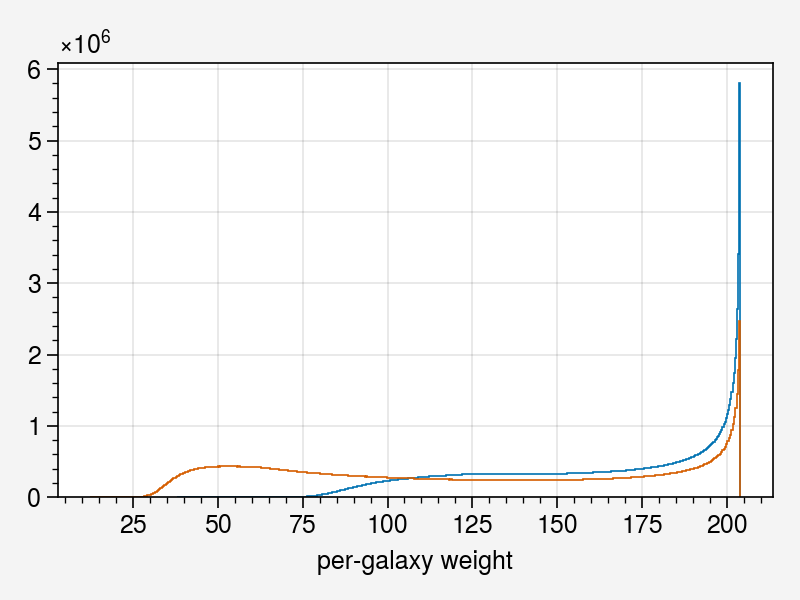

In [7]:
fig,ax=plt.subplots(figsize=(4,3))
h = ax.hist(d_v2_snweight['w'], histtype='step', bins=500)
wgt2 = 1/(0.07**2 + )
h = ax.hist(wgt2, histtype='step', bins=500)
ax.set_xlabel('per-galaxy weight')
plt.tight_layout()

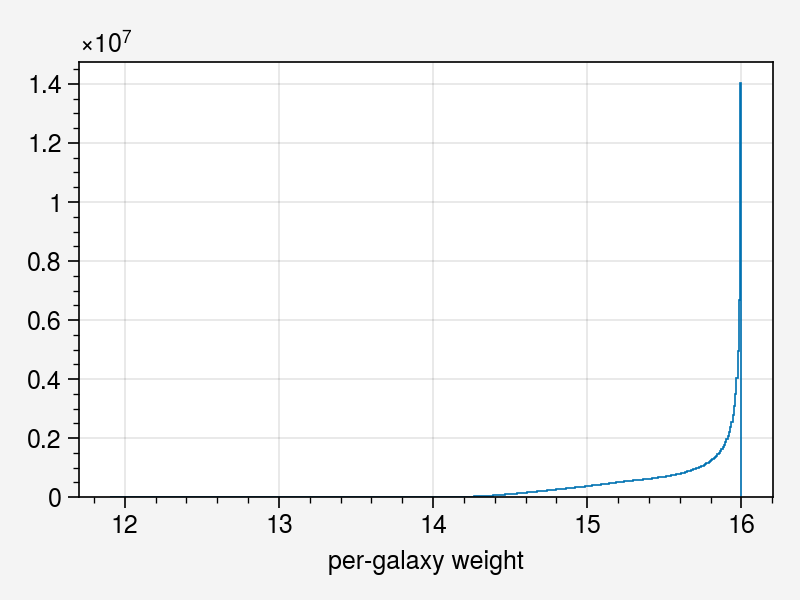

In [6]:
fig,ax=plt.subplots(figsize=(4,3))
wgt = 1/(0.25**2 + 0.5*(d_v2_snweight['g1_cov'] + d_v2_snweight['g2_cov']))
h = ax.hist(wgt, histtype='step', bins=500)
ax.set_xlabel('per-galaxy weight')
plt.tight_layout()